# Finding the best model for text classification
---
- Previously in [Part - 2](https://github.com/mananm98/Reddit-Flair-Predictor/blob/master/Part%20-%202%20Exploratory%20Data%20Analysis.ipynb) I explored a range of linguistic features to distinguish between different reddit flairs
- In this notebook, I will be using those features to build a classification model 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
import keras
import h5py

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [0]:
# load Data
data = pd.read_csv('/content/drive/My Drive/reddit-data-cleaned.csv')

In [0]:
data.head()

,title,score,body,url,num_comments,comments,flair,id
0,delhi govt source names cm arvind kejriwal dep...,302,NaN,ani status,30,beyond petty inclusion delhi government school...,Scheduled,f7ogd8
1,delhi ap singh advocate delhi gang rape convic...,17,NaN,ani status,22,hunch guy try expose loophole legal system nev...,Scheduled,flgvah
2,supreme court verdict sc st quota create polit...,106,NaN,scroll article supreme courts verdict sc st qu...,47,muslim reservation two distraction use indian ...,Scheduled,f1o839
3,entrance exam schedule may,9,clat ailet neet jee postpone two week would ab...,india comments fvcvo entrance exams scheduled may,3,bachega india tabhi toh padhega india gand mar...,Scheduled,fvcvo1
4,advisory schedule international mercial passen...,36,NaN,pib india status,4,oh boy chalo bhaisahab sabji ka dukaan main da...,Scheduled,fl8zf5


## **1. Bag of words Model on conventional ML algorithms**
---
- We cannot input text directly to machine learning models. We need to convert the text to a vector of numbers, this step is called **Feature extraction**
  
    
- For this we are going to use B.O.W (Bag of words) model, It focuses only on the occurence of words. The sentence structure, context, order of words is lost in B.O.W model.


- First we will convert each document in corpus to TF-IDF vector

  
- We will input these vectors to Machine Learning models like Naive-Bayes, Support-Vector-Machine, Logistic-Regression, Random-Forest 



### **Preparing data for model**
---

- It is possible that some features from the dataset may perform better than others. For instance, Only using **Title** for our model may give better accuracy than using only **url**, or maybe a combination of such features might result in a better accuracy. 

  
- this is hard to guess at the moment, so I plan to try out different combinations of inputs from the dataset to get the best accuracy:- Title, url, comments, (Title + url + comments), (Title + url) , etc.

  
- lets see which performs the best, we will use those features in our final model.


In [0]:
def prepare_data(columns):
    # Prepares Train and test sets for models
        
    if len(columns) > 2:
        df = data[columns].fillna("")
        columns.remove('flair')
        X = df[columns].apply(lambda x : ' '.join(x),axis = 1)                     
       
    else :
        df = data[columns].dropna()
        X = df[columns[0]]
        
    X = X.values          # X - input
    
    le = LabelEncoder()
    Y = le.fit_transform(df['flair'])    # Y - target_labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)   # ( 85 : 15 )
    return (X_train, X_test, y_train, y_test)

### **1.1 Title**

In [0]:
# Extracting 'Title' from dataset
(X_train, X_test, y_train, y_test) = prepare_data(['title','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


### Data is ready now we'll apply it to different classifiers
---
1. Linear SVC
2. Naive - Bayes
3. Logistic Regression
4. Random Forest classifier

In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.2)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 0.9)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100,max_depth=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        # tf-idf vectorisation
                    (clf[0],clf[1])                                            # estimator
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.7194029850746269

Naive - Bayes   ----->   0.7074626865671642

LogisticRegression   ----->   0.746268656716418

Random Forest Classifier   ----->   0.7134328358208956



### **1.2 URL** 

In [0]:
# Extracting url column from dataset
(X_train, X_test, y_train, y_test) = prepare_data(['url','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1890,)
y_train shape  =  (1890,)
X_test shape  =  (334,)
y_test shape  =  (334,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.7)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 25,solver='saga',penalty='l1',multi_class='multinomial')) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100,max_depth=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.5269461077844312

Naive - Bayes   ----->   0.4431137724550898



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression   ----->   0.5239520958083832

Random Forest Classifier   ----->   0.5



### **1.3 Comments**

In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['comments','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1706,)
y_train shape  =  (1706,)
X_test shape  =  (302,)
y_test shape  =  (302,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=1)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 10)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.5132450331125827

Naive - Bayes   ----->   0.4105960264900662



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression   ----->   0.49337748344370863

Random Forest Classifier   ----->   0.423841059602649



### **1.4 Title + url**

In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['title','url','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.7)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 0.9)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.7283582089552239

Naive - Bayes   ----->   0.6925373134328359

LogisticRegression   ----->   0.7283582089552239

Random Forest Classifier   ----->   0.7074626865671642



### **1.5 Title + comments**

In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['title','comments','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.6)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 9,max_iter = 150)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.7432835820895523

Naive - Bayes   ----->   0.5671641791044776

LogisticRegression   ----->   0.7194029850746269

Random Forest Classifier   ----->   0.7134328358208956



### **1.6 Title + body**

In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['title','body','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.7)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 9,max_iter = 200)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.8238805970149253

Naive - Bayes   ----->   0.6716417910447762

LogisticRegression   ----->   0.7970149253731343

Random Forest Classifier   ----->   0.7611940298507462



### **1.7 Title + comments + url**


In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['title','url','comments','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=3)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 9,max_iter = 150)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test)
    accuracy = np.sum(predicted == y_test)/len(y_test)
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.7761194029850746

Naive - Bayes   ----->   0.5940298507462687



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression   ----->   0.7343283582089553

Random Forest Classifier   ----->   0.7134328358208956



###  **1.8 Title + body + url**

In [0]:
(X_train, X_test, y_train, y_test) = prepare_data(['title','body','url','flair'])
print("X_train shape  = ",X_train.shape)
print("y_train shape  = ",y_train.shape)
print("X_test shape  = ",X_test.shape)
print("y_test shape  = ",y_test.shape)

X_train shape  =  (1892,)
y_train shape  =  (1892,)
X_test shape  =  (335,)
y_test shape  =  (335,)


In [0]:
classifiers = [ ('LinearSVC',LinearSVC(loss='hinge',C=0.7)) , ('Naive - Bayes',MultinomialNB() ),('LogisticRegression' ,LogisticRegression(C = 9,max_iter = 200)) ,('Random Forest Classifier' ,RandomForestClassifier(n_estimators=100)) ]
for clf in classifiers:
    
    text_clf = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2))),        
                    (clf[0],clf[1])                                            
                   ])
    
    text_clf.fit(X_train,y_train)
    predicted =  text_clf.predict(X_test) 
    accuracy = np.sum(predicted == y_test)/len(y_test) # t = b = u
    print(clf[0],'  ----->  ',accuracy,end = '\n\n')

LinearSVC   ----->   0.8238805970149253

Naive - Bayes   ----->   0.6716417910447762

LogisticRegression   ----->   0.7970149253731343

Random Forest Classifier   ----->   0.7880597014925373



#### ***Models perform the best when we use features ( Title + Body + url )***
- Now we will explore deep-learning approaches for text classification



# ***2. Deep Learning Models***
- We will be considering the following deep learning methods for text classification
 1. CNN + Word Embeddings
 2. LSTMs
 3. Stacked LSTMS
 4. Bidirectional LSTMs
 5. Hybrid Model --> (CNN + LSTM)

In [0]:
# Creating embeddings dictionary
embeddings_dict = {}
with open('/content/drive/My Drive/glove.6B.50d.txt') as f: 
    for line in f:
        word = line.split()[0]
        embeddings_dict[word] = np.array(line.split()[1:],dtype = 'float')

In [0]:
def prepare_data(columns):
    # Prepares Train and test sets for models
        
    if len(columns) > 2:
        df = data[columns].fillna("")
        columns.remove('flair')
        X = df[columns].apply(lambda x : ' '.join(x),axis = 1)                     
       
    else :
        df = data[columns].dropna()
        X = df[columns[0]]
        
    X = X.values          # X - input
    
    le = LabelEncoder()
    Y = le.fit_transform(df['flair'])    # Y - target_labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)   # ( 85 : 15 )
    return (X_train, X_test, y_train, y_test,le)

def create_data_for_model(max_len , vocab_size = 'None'):
      '''- Function to create data for Deep Learning Models

       - Parameters :-
         max_len : maximum length of input vector to model, vectors greater than max_len are truncated, vectors smaller than max_len are padded 
         vocab_size : size of vocabulary  

       - Returns :-
         padded_train : padded integer vectors representing X_train, each word in X_train is mapped to a unique integer
         padded_test : padded integer vectors representing X_test
         y_train : one_hot encoded target labels
         y_test : Test -  target labels
         embeddings_matrix : matrix of size (vocab_size+1,50), contains word embeddings for words in dataset  
         vocab_size : size of vocabulary
         cache :   dictionary to store objects that will be needed when deploying model

        '''


      cache = {}  # dictionary to store objects that will be needed when deploying model
      (X_train, X_test, y_train, y_test, label_encoder) = prepare_data(['title','body','url','flair'])
      tk = Tokenizer()
      tk.fit_on_texts(X_train)
      if vocab_size != 'None':
        tk.word_index = {w:i for w,i in tk.word_index.items() if i <= vocab_size}
      else:
        vocab_size = len(tk.word_index)

      # Train Data - X
      encoded_train = tk.texts_to_sequences(X_train)
      padded_train = pad_sequences(encoded_train,maxlen = max_len, padding = 'post' , truncating = 'post')

      # Test Data  - X
      encoded_test = tk.texts_to_sequences(X_test)
      padded_test = pad_sequences(encoded_test,maxlen = max_len,padding = 'post', truncating = 'post')

      # Train Data - Y
      one_hot = OneHotEncoder()
      y_train = y_train.reshape((-1,1))
      y_train = one_hot.fit_transform(y_train).toarray()

      # Create embeddings matrix
      embeddings_matrix = np.zeros((vocab_size+1,50)) 
      for word,index in tk.word_index.items():
        if embeddings_dict.get(word) is not None:
          embeddings_matrix[index] = embeddings_dict[word]
     
      cache['Label_Encoder'] = label_encoder
      cache['tokenizer'] = tk
      return (padded_train, y_train, padded_test, y_test, embeddings_matrix, vocab_size, cache)

def give_accuracy(model,x_test,y_test,name):
    predicted = model.predict(padded_test)
    predicted_labels = np.argmax(predicted,axis = 1)
    accuracy = np.sum(predicted_labels == y_test)/len(y_test)
    print("Accuracy of " + str(name) + " model ---> ", accuracy)


## ***2.1 CNN + Word Embeddings***
- (**Yoav Goldberg**, in his primer on deep learning for nlp, 2015) , comments that CNNs are effective at Text Classification because of their capability to extract important features  (like tokens or sequence of tokens) regardless of their position in text.

- He also comments, in text classification, the main idea is to learn words or a group of words that are good indicators of a topic, we do not necessarily care where they might appear in a document. Convolutions and pooling layers allow model to learn such local indicators invariant to their position.
---
1. For each training example, we will extract word embedding vectors (Glove vectors).
2. we will feed this as input to CNN model, Our hope is that CNN model will learn some useful filters. A useful filter might be one , that has a similar embedding vector to the vector of a distinguishing word.
    
      
![alt text](https://github.com/mananm98/Reddit-Flair-Predictor/blob/master/images/cnn.JPG?raw=true)

  
    
      
- In the image above, the filter has very similar weights to the bigram --> cat sitting. Therefore it gives a high activation.

- In the next sentence it also give a high activation because the cosine distance between the vectors cat-dog and sitting-resting is very small. This is the reason to use word embeddings, they provide us with similar representations for similar words.

- So, the result is that we have learnt a filter that will give high activation whenever it comes across a bigram that means "animal resting". Such filters help in extracting general meanings from text 

- They can be used by the model to understand what our text conveys,  and consequently give correct output





In [0]:
 (padded_train, y_train, padded_test, y_test, embeddings_matrix, vocab_len, cache) = create_data_for_model(max_len = 300)
def create_cnn_model(max_len, vocab_size):  
  pooling_layers = []
  inp = Input((max_len,))
  embedding_layer = Embedding(input_dim= vocab_size + 1,output_dim=50,weights = [embeddings_matrix],trainable = True)(inp)
  dp = Dropout(0.3)(embedding_layer)

  x1 = Conv1D(filters=36,kernel_size=1,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len ,stride = 1)(x1))

  x2 = Conv1D(filters=36,kernel_size=2,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 1,stride = 1)(x2))

  x3 = Conv1D(filters=36,kernel_size=3,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 2,stride = 1)(x3))

  x4 = Conv1D(filters=36,kernel_size=4,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 3,stride = 1)(x4))

  x5 = Conv1D(filters=36,kernel_size=5,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 4,stride = 1)(x5))

  z = Concatenate(axis = 1)(pooling_layers)
  z = Flatten()(z)
  z = Dropout(0.2)(z)

  
  #y = Dense(16,activation = 'relu')(z)

  out = Dense(11,activation = 'softmax')(z)


  model = Model(inputs = inp,outputs = out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [0]:
cnn_model = create_cnn_model(max_len = 300,vocab_size = vocab_len)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 50)      1018350     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 300, 50)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 300, 36)      1836        dropout_5[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=300, strides=1)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=299, strides=1)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=298, strides=1)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=297, strides=1)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=296, strides=1)`


In [0]:
history = cnn_model.fit(padded_train,y_train, epochs = 65, batch_size = 32, validation_split = 0.15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1608 samples, validate on 284 samples
Epoch 1/65
1608/1608 [==============================] - 1s 597us/step - loss: 3.0295 - accuracy: 0.1300 - val_loss: 2.0065 - val_accuracy: 0.3451
Epoch 2/65
1608/1608 [==============================] - 1s 357us/step - loss: 2.3507 - accuracy: 0.2525 - val_loss: 1.6365 - val_accuracy: 0.5246
Epoch 3/65
1608/1608 [==============================] - 1s 360us/step - loss: 1.9897 - accuracy: 0.3700 - val_loss: 1.3972 - val_accuracy: 0.6056
Epoch 4/65
1608/1608 [==============================] - 1s 358us/step - loss: 1.6783 - accuracy: 0.4596 - val_loss: 1.2280 - val_accuracy: 0.6514
Epoch 5/65
1608/1608 [==============================] - 1s 357us/step - loss: 1.4471 - accuracy: 0.5187 - val_loss: 1.0496 - val_accuracy: 0.6796
Epoch 6/65
1608/1608 [==============================] - 1s 356us/step - loss: 1.2409 - accuracy: 0.6113 - val_loss: 0.9310 - val_accuracy: 0.7042
Epoch 7/65
1608/1608 [==============================] - 1s 356us/step - loss:

In [0]:
# accuracy
give_accuracy(cnn_model,padded_test, y_test, "CNN")

Accuracy of CNN model --->  0.8477611940298507


In [0]:
# saving model as it performed the best
cnn_model.save('/content/drive/My Drive/Reddit_models/model_CNN.h5')
# saving cache
with open('/content/drive/My Drive/Reddit_models/model_CNN_cache.pickle', 'wb') as f:
  pickle.dump(cache,f, protocol=pickle.HIGHEST_PROTOCOL)

0.8477611940298507 saved


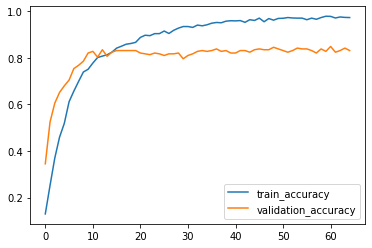

In [0]:
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

# **2. LSTM**
- The idea behind using LSTMs is to capture context and the order of text.

- LSTMs can remember past information using hidden states and apply it to current task

- Consider a sentence --> **The movie was not good, even though everyone was claiming it to be awesome, brilliant, extraordinary!**

- To detect sentiment of this text, if we apply a CNN or linear classifier, it may predict that text is positive base on the words -  good, awesome, brilliant, extraordinary

- But a LSTM might be able to recognize that due to the presence of 'not good' , 'even though' our sentence is actually negative

- ***LSTMs are slow to train so I will set max_len = median length of texts(i.e 35)***

In [0]:
(padded_train, y_train, padded_test, y_test, embeddings_matrix, vocab_len,cache) = create_data_for_model(max_len = 35) # taking max_len = median

In [0]:
# Model
def model_lstm(max_len,vocab_size):
  inp1 = Input((max_len,))
  embedding_layer = Embedding(input_dim=vocab_size + 1,output_dim= 50,mask_zero=True,weights = [embeddings_matrix],trainable = False)(inp1)
  drop_out1 = Dropout(0.3)(embedding_layer)
  lstm_layer1 = LSTM(100,return_sequences = False)(drop_out1)


  #drop_out = Dropout(0.3)(lstm_layer1)
  out1 = Dense(11,activation='softmax')(lstm_layer1)

  model_lstm = Model(inputs = inp1,outputs = out1)
  model_lstm.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model_lstm.summary()
  return model_lstm

In [0]:
lstm_model = model_lstm(max_len = 35,vocab_size=vocab_len)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 35, 50)            1018350   
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1111      
Total params: 1,079,861
Trainable params: 61,511
Non-trainable params: 1,018,350
_________________________________________________________________


In [0]:
hist = lstm_model.fit(padded_train,y_train,epochs = 40, batch_size=8,validation_split = 0.15)

Train on 1608 samples, validate on 284 samples
Epoch 1/40
1608/1608 [==============================] - 17s 11ms/step - loss: 2.0172 - accuracy: 0.3203 - val_loss: 1.6760 - val_accuracy: 0.4577
Epoch 2/40
1608/1608 [==============================] - 16s 10ms/step - loss: 1.5779 - accuracy: 0.4969 - val_loss: 1.4176 - val_accuracy: 0.5563
Epoch 3/40
1608/1608 [==============================] - 16s 10ms/step - loss: 1.3635 - accuracy: 0.5752 - val_loss: 1.3746 - val_accuracy: 0.5317
Epoch 4/40
1608/1608 [==============================] - 16s 10ms/step - loss: 1.2488 - accuracy: 0.6001 - val_loss: 1.2108 - val_accuracy: 0.6021
Epoch 5/40
1608/1608 [==============================] - 18s 11ms/step - loss: 1.0904 - accuracy: 0.6517 - val_loss: 1.1711 - val_accuracy: 0.6338
Epoch 6/40
1608/1608 [==============================] - 18s 11ms/step - loss: 1.0041 - accuracy: 0.6754 - val_loss: 1.0615 - val_accuracy: 0.6549
Epoch 7/40
1608/1608 [==============================] - 17s 11ms/step - loss:

In [0]:
give_accuracy(lstm_model, padded_test, y_test, "LSTM")

Accuracy of LSTM model --->  0.6835820895522388


#### **I even tried Stacked LSTMs but there was not much improvement in accuracy**

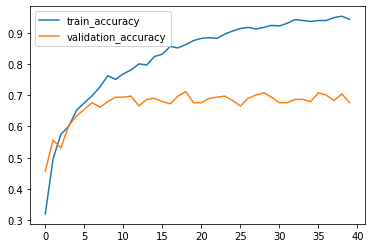

In [0]:
plt.plot(hist.history['accuracy'],label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

# ***3. Bidirectional LSTM***

- The intuition behind using Bidirectional LSTMs is that they learn contextual information from both directions. This may help model to predict better outputs for text classification
![alt text](https://github.com/mananm98/Reddit-Flair-Predictor/blob/master/images/Bidirectional_Lstm.jpg?raw=true)

In [0]:
(padded_train, y_train, padded_test, y_test, embeddings_matrix, vocab_len,cache) = create_data_for_model(max_len = 35)

In [0]:
def create_biLSTM_model(max_len,vocab_size):
  inp1 = Input((max_len,))
  embedding_layer = Embedding(input_dim=vocab_size + 1,output_dim= 50,mask_zero=True,weights = [embeddings_matrix],trainable = True)(inp1)
  drop_out1 = Dropout(0.3)(embedding_layer)
  lstm_layer1 = Bidirectional(LSTM(100,return_sequences = False))(drop_out1)


  #drop_out = Dropout(0.3)(lstm_layer1)
  out1 = Dense(11,activation='softmax')(lstm_layer1)

  model_bi_lstm = Model(inputs = inp1,outputs = out1)
  model_bi_lstm.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model_bi_lstm.summary()
  return model_bi_lstm

In [0]:
model_bi_lstm = create_biLSTM_model(max_len = 35, vocab_size = vocab_len)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 35)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 35, 50)            1018350   
_________________________________________________________________
dropout_19 (Dropout)         (None, 35, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               120800    
_________________________________________________________________
dense_12 (Dense)             (None, 11)                2211      
Total params: 1,141,361
Trainable params: 1,141,361
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model_bi_lstm.fit(padded_train,y_train,epochs = 40, batch_size=16,validation_split = 0.15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1608 samples, validate on 284 samples
Epoch 1/40
1608/1608 [==============================] - 28s 17ms/step - loss: 1.9197 - accuracy: 0.3744 - val_loss: 1.4461 - val_accuracy: 0.5599
Epoch 2/40
1608/1608 [==============================] - 28s 17ms/step - loss: 1.2998 - accuracy: 0.6026 - val_loss: 1.1966 - val_accuracy: 0.6338
Epoch 3/40
1608/1608 [==============================] - 27s 17ms/step - loss: 1.0154 - accuracy: 0.6785 - val_loss: 1.0711 - val_accuracy: 0.6549
Epoch 4/40
1608/1608 [==============================] - 27s 17ms/step - loss: 0.8234 - accuracy: 0.7413 - val_loss: 1.0049 - val_accuracy: 0.6866
Epoch 5/40
1608/1608 [==============================] - 27s 17ms/step - loss: 0.6859 - accuracy: 0.7842 - val_loss: 0.9191 - val_accuracy: 0.7042
Epoch 6/40
1608/1608 [==============================] - 27s 17ms/step - loss: 0.5248 - accuracy: 0.8414 - val_loss: 0.9393 - val_accuracy: 0.7148
Epoch 7/40
1608/1608 [==============================] - 27s 17ms/step - loss:

In [0]:
give_accuracy(model_bi_lstm, padded_test, y_test, "Bidirectional_LSTM")

Accuracy of Bidirectional_LSTM model --->  0.764179104477612


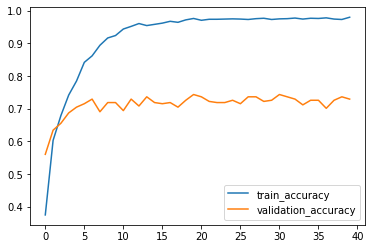

In [0]:
plt.plot(hist.history['accuracy'],label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

# **5. Hybrid  - CNN + LSTM**
- With a Hybrid model of CNN and LSTM. I plan to combine the merits of both models
- first a CNN model will extract best features from input Word Embeddings
- Then these features will be fed to LSTM to learn context. 
- The hope is that CNN will aid LSTM in learning, by providing only useful information. This should lead to a boost in accuracy.

![hybrid-model](https://www.researchgate.net/profile/Jin_Wang115/publication/306093564/figure/fig1/AS:394871950069760@1471156217020/System-architecture-of-the-proposed-regional-CNN-LSTM-model.png)





[referenced from here](https://www.researchgate.net/figure/System-architecture-of-the-proposed-regional-CNN-LSTM-model_fig1_306093564)

In [0]:
(padded_train, y_train, padded_test, y_test, embeddings_matrix,vocab_len,cache) = create_data_for_model(max_len = 35)

In [0]:
def create_hybrid_model(max_len,vocab_size):

  pooling_layers = []


  inp1 = Input((max_len,))
  embedding_layer = Embedding(input_dim=vocab_size + 1,output_dim= 50,mask_zero=False,weights = [embeddings_matrix],trainable = True)(inp1)
  dp = Dropout(0.3)(embedding_layer)

  x1 = Conv1D(filters=36,kernel_size=1,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 19,stride = 1)(x1))

  x2 = Conv1D(filters=36,kernel_size=2,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 20,stride = 1)(x2))

  x3 = Conv1D(filters=36,kernel_size=3,activation = 'relu')(dp)
  pooling_layers.append(MaxPool1D(pool_size=max_len - 21,stride = 1)(x3))

  z = Concatenate(axis = 2)(pooling_layers)
  drop_out = Dropout(0.3)(z)

  lstm_layer1 = Bidirectional(LSTM(100,return_sequences = False))(drop_out)


  drop_out = Dropout(0.3)(lstm_layer1)
  out1 = Dense(11,activation='softmax')(lstm_layer1)

  hybrid_model = Model(inputs = inp1,outputs = out1)
  hybrid_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  hybrid_model.summary()
  return hybrid_model

In [0]:
hybrid_model = create_hybrid_model(35,vocab_size=vocab_len)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=16, strides=1)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=15, strides=1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=14, strides=1)`


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 35, 50)       1018350     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 35, 50)       0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 35, 36)       1836        dropout_8[0][0]                  
____________________________________________________________________________________________

In [0]:
hist = hybrid_model.fit(padded_train,y_train,epochs = 40, batch_size=8,validation_split = 0.15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1608 samples, validate on 284 samples
Epoch 1/40
1608/1608 [==============================] - 18s 11ms/step - loss: 2.2558 - accuracy: 0.2009 - val_loss: 1.9366 - val_accuracy: 0.2958
Epoch 2/40
1608/1608 [==============================] - 17s 10ms/step - loss: 1.7326 - accuracy: 0.4229 - val_loss: 1.3480 - val_accuracy: 0.5599
Epoch 3/40
1608/1608 [==============================] - 16s 10ms/step - loss: 1.3115 - accuracy: 0.5808 - val_loss: 1.1601 - val_accuracy: 0.6444
Epoch 4/40
1608/1608 [==============================] - 16s 10ms/step - loss: 1.0661 - accuracy: 0.6667 - val_loss: 1.0334 - val_accuracy: 0.6725
Epoch 5/40
1608/1608 [==============================] - 16s 10ms/step - loss: 0.9099 - accuracy: 0.7071 - val_loss: 1.0599 - val_accuracy: 0.6866
Epoch 6/40
1608/1608 [==============================] - 16s 10ms/step - loss: 0.8113 - accuracy: 0.7407 - val_loss: 1.0007 - val_accuracy: 0.6831
Epoch 7/40
1608/1608 [==============================] - 16s 10ms/step - loss:

In [0]:
give_accuracy(hybrid_model,padded_test,y_test,"Hybrid Model")

Accuracy of Hybrid Model model --->  0.7492537313432835


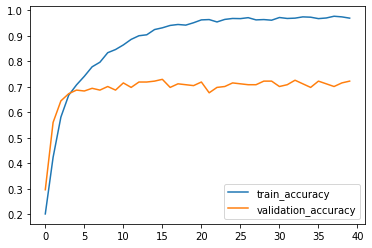

In [0]:
plt.plot(hist.history['accuracy'],label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()